In [1]:
using Pkg
cmdir=joinpath(ENV["DATA"], "HD5t/precdr")
pdir =joinpath(ENV["PROJECTS"], "Petit")

Pkg.activate(pdir)
Pkg.instantiate()


  Activating project at `~/Projects/Petit`


In [2]:
using Petit
using Revise
using Plots
using DataFrames
using Statistics
using Images
using HDF5
using CSV
using Base: basename
using Printf
using ImageIO, Noise, ImageShow, ImageFiltering
using LaTeXStrings
using Images, TestImages, Deconvolution, Random
using FFTW

In [3]:
function ingredients(path::String)
    # this is from the Julia source code (evalfile in base/loading.jl)
    # but with the modification that it returns the module instead of the last object
    name = Symbol(basename(path))
    m = Module(name)
    Core.eval(m,
        Expr(:toplevel,
                :(eval(x) = $(Expr(:core, :eval))($name, x)),
                :(include(x) = $(Expr(:top, :include))($name, x)),
                :(include(mapexpr::Function, x) = $(Expr(:top, :include))(mapexpr, $name, x)),
                :(include($path))))
    m
end

ingredients (generic function with 1 method)

In [4]:
jn = ingredients(string(pdir,"/src/Petit.jl"))

Main.var"Petit.jl"

In [5]:
# Gaussian PSF (odd size; σ in pixels)
function gaussian_psf(n::Int, σ::Float64)
    @assert isodd(n) "PSF size n must be odd"
    r = -div(n,2):div(n,2)
    g = exp.(-(r.^2) ./ (2σ^2))
    psf = g * g'                 # 2D separable Gaussian
    psf ./= sum(psf)             # normalize
    return Float32.(psf)
end

gaussian_psf (generic function with 1 method)

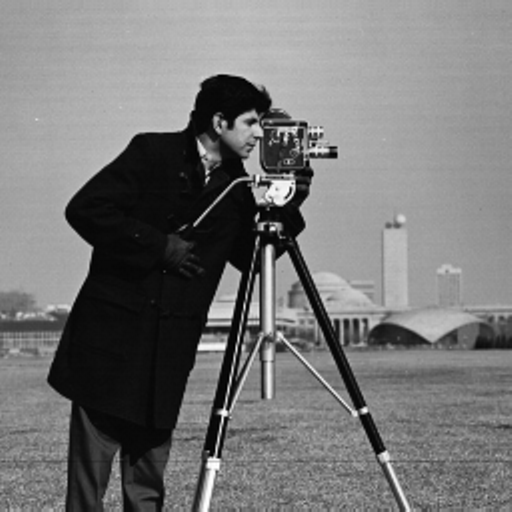

In [6]:
img = Float32.(testimage("cameraman"))
img ./= maximum(img)
Gray.(img)

In [7]:
psf_small = gaussian_psf(15, 2.0)

15×15 Matrix{Float32}:
 1.90451f-7  9.67192f-7   3.82532f-6   …  9.67192f-7   1.90451f-7
 9.67192f-7  4.91181f-6   1.94266f-5      4.91181f-6   9.67192f-7
 3.82532f-6  1.94266f-5   7.68336f-5      1.94266f-5   3.82532f-6
 1.17828f-5  5.98381f-5   0.000236664     5.98381f-5   1.17828f-5
 2.82655f-5  0.000143544  0.000567728     0.000143544  2.82655f-5
 5.28069f-5  0.000268176  0.00106066   …  0.000268176  5.28069f-5
 7.68336f-5  0.000390193  0.00154324      0.000390193  7.68336f-5
 8.70639f-5  0.000442147  0.00174872      0.000442147  8.70639f-5
 7.68336f-5  0.000390193  0.00154324      0.000390193  7.68336f-5
 5.28069f-5  0.000268176  0.00106066      0.000268176  5.28069f-5
 2.82655f-5  0.000143544  0.000567728  …  0.000143544  2.82655f-5
 1.17828f-5  5.98381f-5   0.000236664     5.98381f-5   1.17828f-5
 3.82532f-6  1.94266f-5   7.68336f-5      1.94266f-5   3.82532f-6
 9.67192f-7  4.91181f-6   1.94266f-5      4.91181f-6   9.67192f-7
 1.90451f-7  9.67192f-7   3.82532f-6      9.67192f-7 

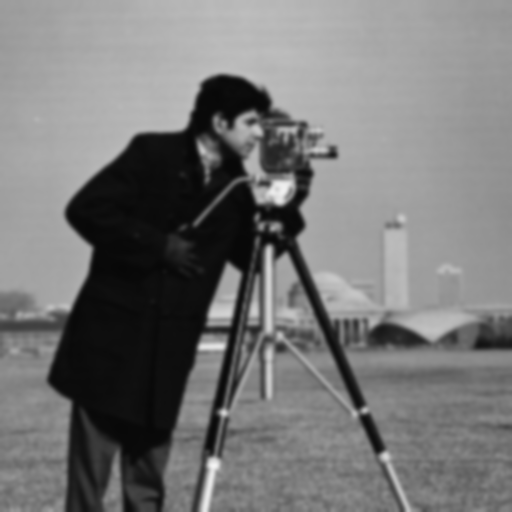

In [8]:
blur = imfilter(img, centered(psf_small), Pad(:reflect))
Gray.(blur)

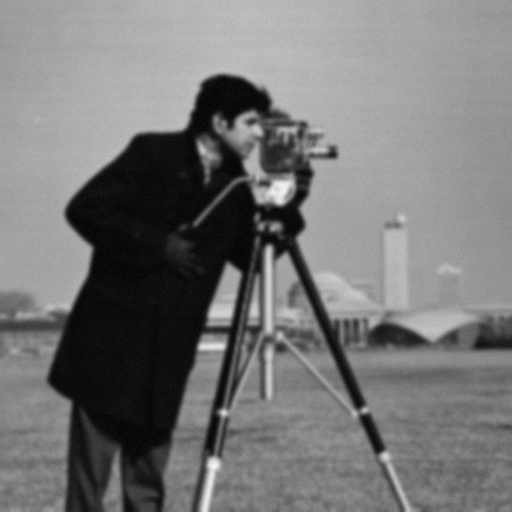

In [9]:
σn = 0.01f0  # noise std in [0,1] units; try 0.005–0.02
blur_gauss = clamp.(blur .+ σn .* randn(Float32, size(blur)), 0f0, 1f0)
Gray.(blur_gauss)

In [10]:
psf_big = zeros(Float32, size(img))
r0, c0 = size(img) .÷ 2
r1, c1 = size(psf_small) .÷ 2
psf_big[(r0 - r1 + 1):(r0 + r1 + 1), (c0 - c1 + 1):(c0 + c1 + 1)] .= psf_small
psf_big ./= sum(psf_big)
psf_big = FFTW.ifftshift(psf_big)

512×512 Matrix{Float32}:
 0.0398008    0.0351241    0.0241404    …  0.0241404    0.0351241
 0.0351241    0.0309969    0.0213038       0.0213038    0.0309969
 0.0241404    0.0213038    0.0146419       0.0146419    0.0213038
 0.0129214    0.0114031    0.00783724      0.00783724   0.0114031
 0.00538645   0.00475353   0.00326705      0.00326705   0.00475353
 0.00174872   0.00154324   0.00106066   …  0.00106066   0.00154324
 0.000442147  0.000390193  0.000268176     0.000268176  0.000390193
 8.70639f-5   7.68336f-5   5.28069f-5      5.28069f-5   7.68336f-5
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 ⋮                                      ⋱  ⋮            
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0        

In [11]:
rest_gauss = lucy(blur_gauss, psf_big; iterations=20)

512×512 Matrix{Float32}:
 0.583878  0.603868  0.611838  0.611142  …  0.553352  0.547712  0.56024
 0.666292  0.677761  0.67429   0.66334      0.629501  0.630184  0.645471
 0.677327  0.684286  0.678062  0.665588     0.645637  0.648529  0.661443
 0.636998  0.643663  0.641906  0.635148     0.617171  0.618496  0.626049
 0.598983  0.606418  0.6093    0.607944     0.58806   0.587595  0.591177
 0.588252  0.5962    0.60065   0.600432  …  0.578983  0.578321  0.581123
 0.598463  0.607147  0.610792  0.608227     0.584757  0.585012  0.589637
 0.612424  0.622601  0.624964  0.619489     0.592239  0.59305   0.600371
 0.617871  0.629837  0.631526  0.62483      0.593535  0.593495  0.602644
 0.613859  0.626711  0.627886  0.621518     0.589476  0.587472  0.596913
 0.606095  0.618282  0.61813   0.611864  …  0.583978  0.580211  0.589078
 0.600687  0.611256  0.60884   0.601129     0.579874  0.575734  0.584305
 0.600335  0.609973  0.605603  0.595343     0.577369  0.574507  0.58388
 ⋮                          

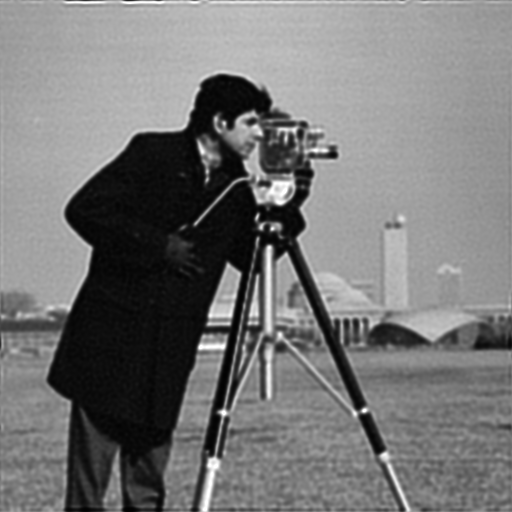

In [12]:
Gray.(rest_gauss)

### Auxiliary functions

In [99]:
# Load auxiliary functions
include("itaca_aux.jl")
println("##Load auxiliary functions")

##Load auxiliary functions


### Diffusion coeficients

In [23]:
sigmat_xe = 3.5 # mm
sigmat_he = 1.5 # mm
sigmal_xe = 0.9 # mm
sigmal_he = 0.75 # mm
kB_ovr_e_lxe = 8.6173E-5 # V/K
kB_ovr_e_gxe = 2.59E-2 # V/K
sigmat_nh4_lxe = sigma_t_ion_mm(170.0, 50.0, 400.0) # 50 cm drift, 400 V/cm
sigmat_nh4_gxe_100 = sigma_t_ion_mm(298.0, 100.0, 400.0) # 100 cm drift, 400 V/cm
sigmat_nh4_gxe_50 = sigma_t_ion_mm(298.0, 50.0, 400.0) # 100 cm drift, 400 V/cm
sigmat_nh4_gxe_10 = sigma_t_ion_mm(298.0, 10.0, 400.0) # 100 cm drift, 400 V/cm

sigmat_e_xe_100 = sigma_t_mm(100.0, 10.0; dtmm=3.5)
sigmat_e_he_100 = sigma_t_mm(100.0, 10.0; dtmm=1.6)
sigmal_e_xe_100 = sigma_l_mm(100.0, 10.0; dlmm=0.9)
sigmal_e_he_100 = sigma_l_mm(100.0, 10.0; dlmm=0.75)

sigmat_e_xe_50 = sigma_t_mm(50.0, 10.0; dtmm=3.5)
sigmat_e_he_50 = sigma_t_mm(50.0, 10.0; dtmm=1.6)
sigmal_e_xe_50 = sigma_l_mm(50.0, 10.0; dlmm=0.9)
sigmal_e_he_50 = sigma_l_mm(50.0, 10.0; dlmm=0.75)

sigmat_e_xe_10 = sigma_t_mm(10.0, 10.0; dtmm=3.5)
sigmat_e_he_10 = sigma_t_mm(10.0, 10.0; dtmm=1.6)
sigmal_e_xe_10 = sigma_l_mm(10.0, 10.0; dlmm=0.9)
sigmal_e_he_10 = sigma_l_mm(10.0, 10.0; dlmm=0.75)

println("| Parameter                  | 100 mm          | 50 mm           | 10 mm           |")
println("|----------------------------|-----------------|-----------------|-----------------|")
println("| Ions (σₜ)                  | $(@sprintf("%.2f", sigmat_nh4_gxe_100)) mm | $(@sprintf("%.2f", sigmat_nh4_gxe_50)) mm | $(@sprintf("%.2f", sigmat_nh4_gxe_10)) mm |")
println("| Electrons in Xe (σₜ)       | $(@sprintf("%.2f", sigmat_e_xe_100)) mm | $(@sprintf("%.2f", sigmat_e_xe_50)) mm | $(@sprintf("%.2f", sigmat_e_xe_10)) mm |")
println("| Electrons in Xe/He (σₜ)    | $(@sprintf("%.2f", sigmat_e_he_100)) mm | $(@sprintf("%.2f", sigmat_e_he_50)) mm | $(@sprintf("%.2f", sigmat_e_he_10)) mm |")
println("| Electrons in Xe (σₗ)       | $(@sprintf("%.2f", sigmal_e_xe_100)) mm | $(@sprintf("%.2f", sigmal_e_xe_50)) mm | $(@sprintf("%.2f", sigmal_e_xe_10)) mm |")
println("| Electrons in Xe/He (σₗ)    | $(@sprintf("%.2f", sigmal_e_he_100)) mm | $(@sprintf("%.2f", sigmal_e_he_50)) mm | $(@sprintf("%.2f", sigmal_e_he_10)) mm |")

| Parameter                  | 100 mm          | 50 mm           | 10 mm           |
|----------------------------|-----------------|-----------------|-----------------|
| Ions (σₜ)                  | 1.13 mm | 0.80 mm | 0.36 mm |
| Electrons in Xe (σₜ)       | 11.07 mm | 7.83 mm | 3.50 mm |
| Electrons in Xe/He (σₜ)    | 5.06 mm | 3.58 mm | 1.60 mm |
| Electrons in Xe (σₗ)       | 2.85 mm | 2.01 mm | 0.90 mm |
| Electrons in Xe/He (σₗ)    | 2.37 mm | 1.68 mm | 0.75 mm |


### Load bb0nu dataframe

In [16]:
xfile = "/Users/jjgomezcadenas/Data/HD5t/lxe/0nubb_100um.next.h5"
filename = basename(xfile)
#hitdf = CSV.read(xfile, DataFrame)
dfs = get_dataset_dfs(xfile)
hitdf = dfs["hits"]
println("Loaded xfile = $(filename)")

Loaded xfile = 0nubb_100um.next.h5


### Analyze events

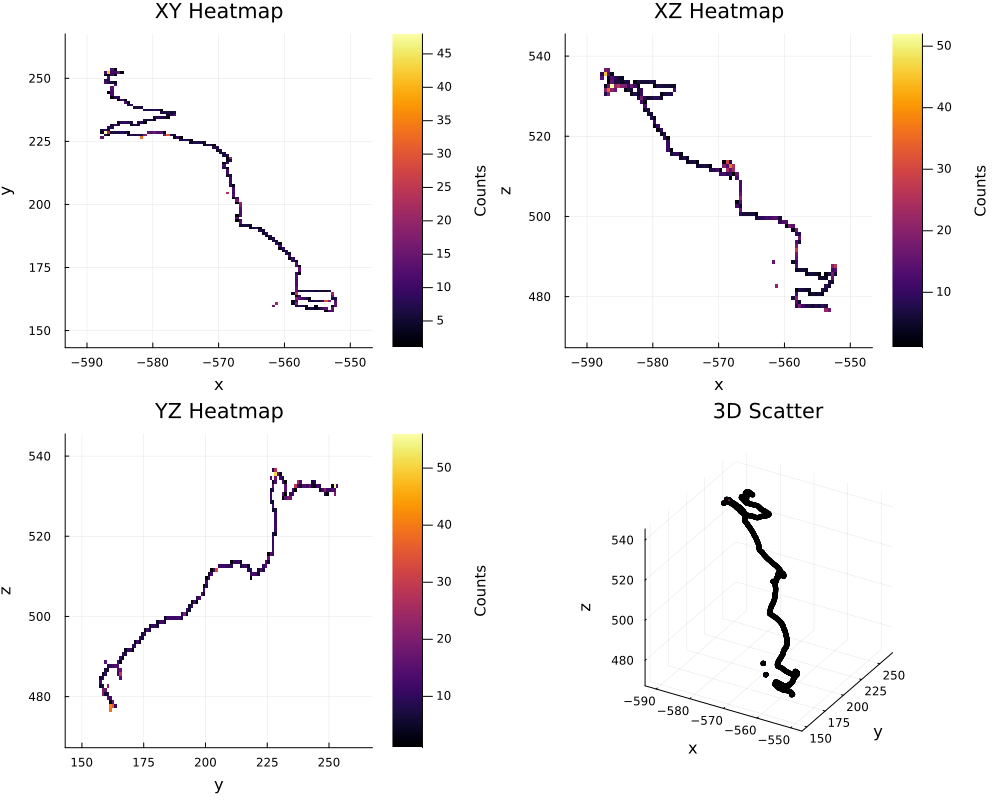

In [17]:
nevent =2
evtdf = get_event(hitdf, nevent)
evtdf.electrons = Int.(round.(evtdf.energy .* 1e5))
#plot_hits_projection(evtdf; projection="xy", nbins=100, background="white")
plot_hits_evt(hitdf, nevent; nbins=100)

In [39]:
#vevt = jn.Petit.voxelize_event(hitdf, nevent, 2.0)
#jn.Petit.plot_event(vevt; nbins=100)

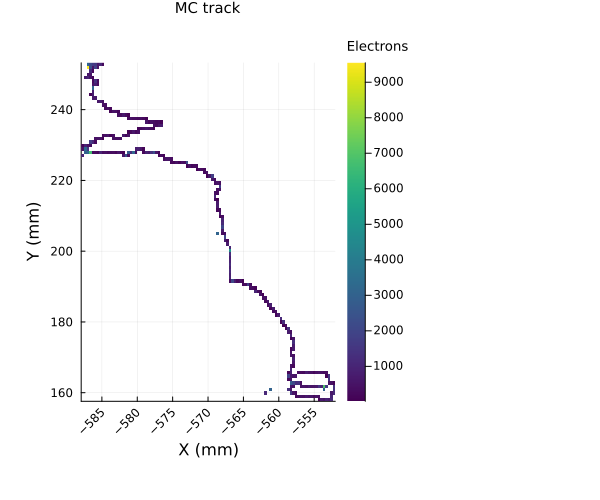

In [18]:
pxymc = plot_hits_projection(evtdf; projection="xy", nbins=100, title="MC track",
                              weight_column=:electrons, background="white",
                              aspect_ratio_limit=(0.5, 0.5),
                              colorbar_title_str="",
                              colorbar_title_location=:top,
                              colorbar_titlefontsize=9,
                              colorbar_tickfontsize=8,
                              right_margin_mm=50,
                              left_margin_mm=6,
                              bottom_margin_mm=6,
                              top_margin_mm=6)

xl = xlims(pxymc); yl = ylims(pxymc)
x_annot = xl[2] + 0.05*(xl[2]-xl[1])   # 5% beyond the right edge
y_annot = yl[2] + 0.05*(yl[2]-yl[1])  # 5% above top

# Now annotate 
annotate!(pxymc, (x_annot, y_annot, text("Electrons", 9, :black, :left)))

$\sigma$


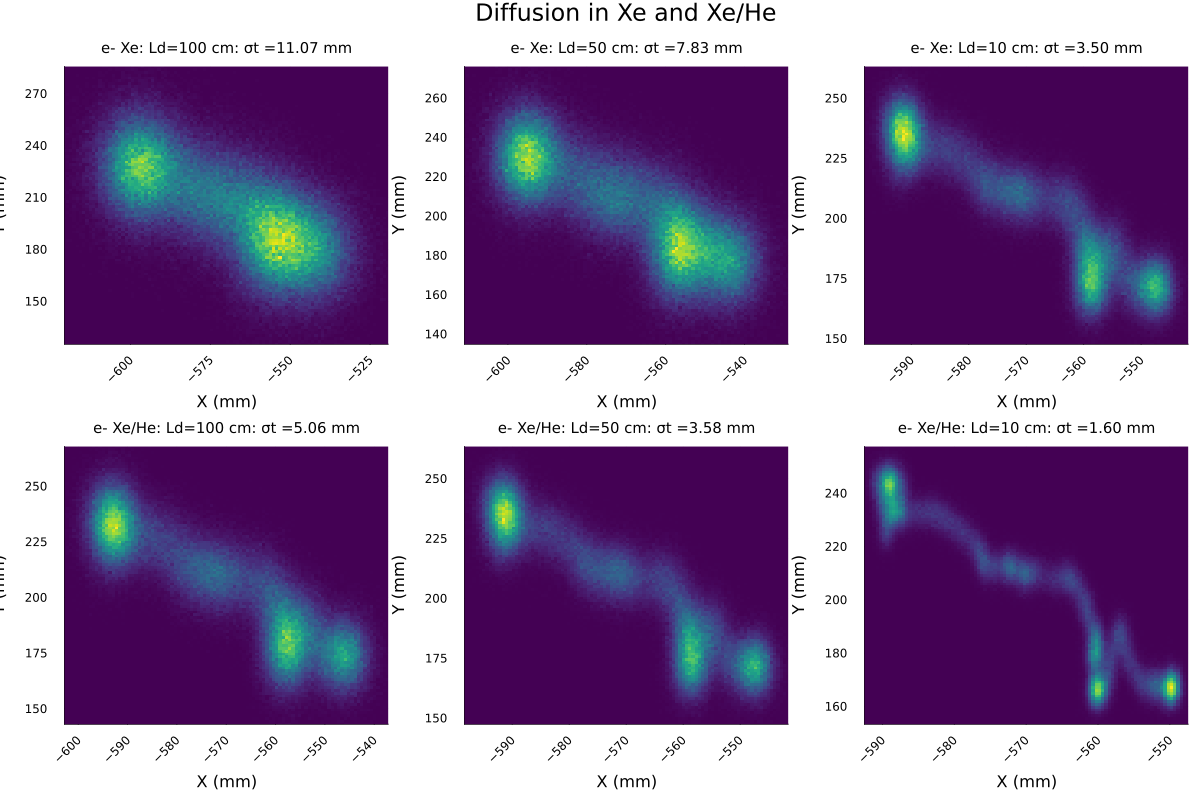

In [103]:
dxy_xe_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_100, nbins=100, nsigma=3.0)
pxe_100 = plot_diffused_xy(dxy_xe_100; title="""e- Xe: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_100)) mm""", colorbar=false)
dxy_xe_50 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_50, nbins=100, nsigma=3.0)
pxe_50 = plot_diffused_xy(dxy_xe_50; title="""e- Xe: Ld=50 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_50)) mm""", colorbar=false)
dxy_xe_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_10, nbins=100, nsigma=3.0)
pxe_10 = plot_diffused_xy(dxy_xe_10; title="""e- Xe: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_10)) mm""", colorbar=false)

dxy_he_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_100, nbins=100, nsigma=3.0)
pxe_100_he = plot_diffused_xy(dxy_he_100; title="""e- Xe/He: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_e_he_100)) mm""", colorbar=false)
dxy_he_50 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_50, nbins=100, nsigma=3.0)
pxe_50_he = plot_diffused_xy(dxy_he_50; title="""e- Xe/He: Ld=50 cm: σt =$(@sprintf("%.2f", sigmat_e_he_50)) mm""", colorbar=false)
dxy_he_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_10, nbins=100, nsigma=3.0)
pxe_10_he = plot_diffused_xy(dxy_he_10; title="""e- Xe/He: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_e_he_10)) mm""", colorbar=false)

dxy_nh4_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_nh4_gxe_100, nbins=100, nsigma=3.0)
pxe_100_nh4 =plot_diffused_xy(dxy_nh4_100; title="""Nh4: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_nh4_gxe_100)) mm""", colorbar=false)

dxy_nh4_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_nh4_gxe_10, nbins=100, nsigma=3.0)
pxe_10_nh4 = plot_diffused_xy(dxy_nh4_10; title="""Nh4: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_nh4_gxe_10)) mm""", colorbar=false)

plot(pxe_100, pxe_50, pxe_10,pxe_100_he, pxe_50_he, pxe_10_he,
       layout=(2, 3),
       size=(1200, 800),
       plot_title="Diffusion in Xe and Xe/He",
       link=:both)  # Links axes if you want them synchronized

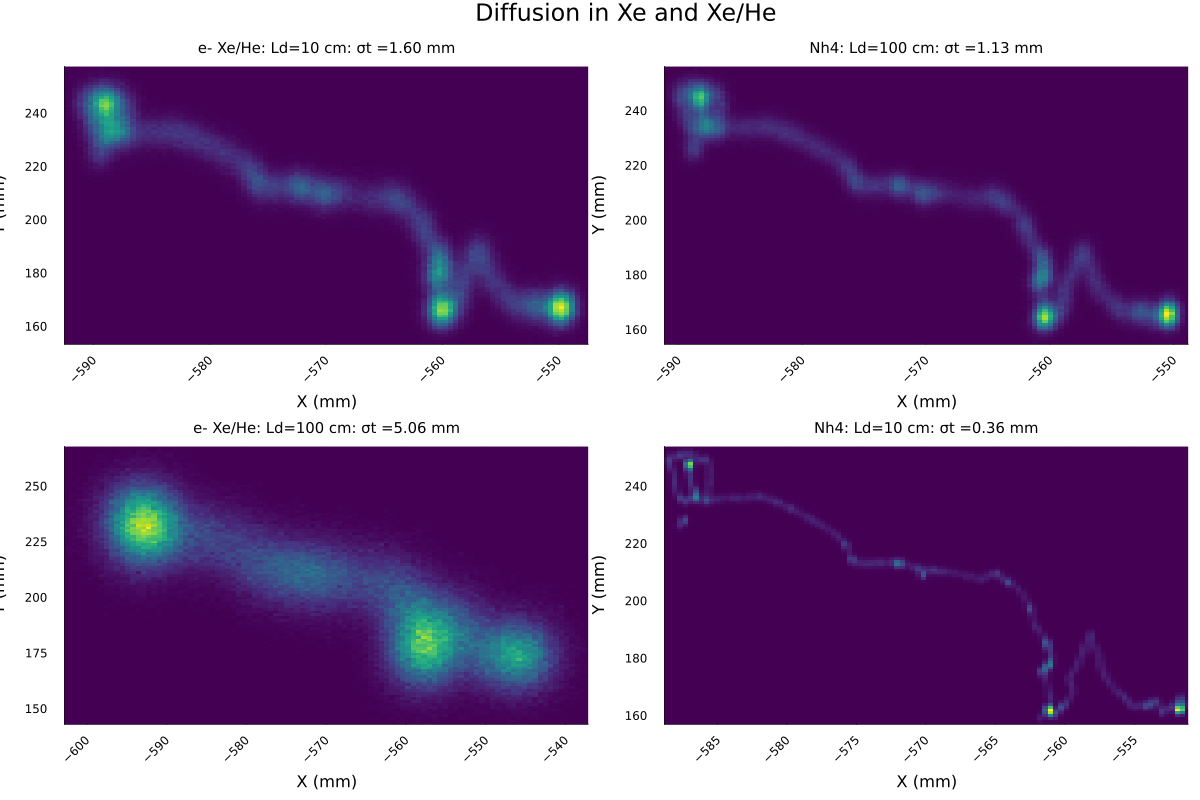

In [105]:
plot(pxe_10_he, pxe_100_nh4, pxe_100_he, pxe_10_nh4,
       layout=(2, 2),
       size=(1200, 800),
       plot_title="Diffusion in Xe and Xe/He",
       link=:both)

In [38]:
max_distance_mm = 10.0
energy_threshold_kev = 1.0
trks = make_tracks(evtdf, nevent;
				   max_dist=max_distance_mm,
				   energy_thr=energy_threshold_kev)
length(trks)

3

### Lxe plots

In [ ]:
dmc =diffuse_xy_image_mc(evtdf; sigma_mm=0.3, nbins=200, nsigma=3.0)
plot_diffused_xy(dmc; title="Event $nevent - Diffused XY")

In [ ]:
0.6/4.0

In [ ]:
1.1/100.0

In [ ]:
dmc =diffuse_xy_image_mc(evtdf; sigma_mm=0.6, nbins=200, nsigma=3.0)
plot_diffused_xy(dmc; title="Event $nevent - Diffused XY")

In [ ]:
dmc =diffuse_xy_image_mc(evtdf; sigma_mm=0.6/2.3, nbins=200, nsigma=3.0)
plot_diffused_xy(dmc; title="Event $nevent - Diffused XY")

In [ ]:
dimg = diffuse_xy_image(evtdf; sigma_mm=0.6/2.3, nbins=100)
p = plot_diffused_xy(dimg; title="Event $nevent - Diffused XY")

In [ ]:
dimg2 = diffuse_xy_image_efficient(evtdf; sigma_mm=0.6, nbins=100)
p = plot_diffused_xy(dimg2; title="Event $nevent - Diffused XY (efficient)")